In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/urbansound8k/UrbanSound8K.csv
/kaggle/input/urbansound8k/fold7/164797-2-0-8.wav
/kaggle/input/urbansound8k/fold7/177537-7-2-0.wav
/kaggle/input/urbansound8k/fold7/177729-0-0-68.wav
/kaggle/input/urbansound8k/fold7/6902-2-0-18.wav
/kaggle/input/urbansound8k/fold7/518-4-0-2.wav
/kaggle/input/urbansound8k/fold7/146845-0-0-2.wav
/kaggle/input/urbansound8k/fold7/116485-3-2-4.wav
/kaggle/input/urbansound8k/fold7/518-4-0-3.wav
/kaggle/input/urbansound8k/fold7/44737-5-0-2.wav
/kaggle/input/urbansound8k/fold7/201988-5-0-3.wav
/kaggle/input/urbansound8k/fold7/181102-9-0-50.wav
/kaggle/input/urbansound8k/fold7/99812-1-6-0.wav
/kaggle/input/urbansound8k/fold7/39857-5-0-0.wav
/kaggle/input/urbansound8k/fold7/61503-2-0-6.wav
/kaggle/input/urbansound8k/fold7/162728-1-0-0.wav
/kaggle/input/urbansound8k/fold7/89443-9-0-48.wav
/kaggle/input/urbansound8k/fold7/168846-5-1-13.wav
/kaggle/input/urbansound8k/fold7/149193-5-0-2.wav
/kaggle/input/urbansound8k/fold7/71529-4-0-2.wav
/kaggle/input/u

# Import Libraries

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import resampy
import librosa
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical

In [3]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.1 MB/s eta 0:00:00a 0:00:01


# Load Data

In [5]:
audio_files_path = "/kaggle/input/urbansound8k/"
df = pd.read_csv("/kaggle/input/urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
data = []
labels = []

for index, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_files_path), "fold" + str(row["fold"]) + "/", str(row["slice_file_name"]))
    audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
    data.append(mfccs_features_scaled)
    labels.append(row["class"])

3554it [04:23, 14.00it/s]/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8326it [09:51, 22.96it/s]/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [10:18, 14.12it/s]


In [7]:
feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df.head()

,features,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [8]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

In [9]:
feature_df["class"] = label_encoder(feature_df["class"])

class ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']


In [30]:
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

In [10]:
feature_df.head()

,features,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",3
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",2
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",2
3,"[-413.89984, 101.66371, -35.42945, 53.036358, ...",2
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",2


# Model

In [12]:
X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
num_labels = len(feature_df["class"].unique())
num_labels

10

In [16]:
input_shape = feature_df["features"][0].shape
input_shape

(40,)

In [17]:
model = Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation(activation="softmax"))

In [18]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5248      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [20]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
219/219 [==============================] - 2s 3ms/step - loss: 9.9994 - accuracy: 0.1261 - val_loss: 2.2850 - val_accuracy: 0.1248
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 2.4501 - accuracy: 0.1211 - val_loss: 2.2718 - val_accuracy: 0.1242
Epoch 3/100
219/219 [==============================] - 0s 2ms/step - loss: 2.3083 - accuracy: 0.1247 - val_loss: 2.2333 - val_accuracy: 0.1483
Epoch 4/100
219/219 [==============================] - 0s 2ms/step - loss: 2.2510 - accuracy: 0.1540 - val_loss: 2.1668 - val_accuracy: 0.1780
Epoch 5/100
219/219 [==============================] - 1s 2ms/step - loss: 2.2020 - accuracy: 0.1662 - val_loss: 2.1035 - val_accuracy: 0.1780
Epoch 6/100
219/219 [==============================] - 0s 2ms/step - loss: 2.1679 - accuracy: 0.1868 - val_loss: 2.0973 - val_accuracy: 0.1740
Epoch 7/100
219/219 [==============================] - 0s 2ms/step - loss: 2.1352 - accuracy: 0.1877 - val_loss: 2.0554 - val_accuracy: 0.2164

In [21]:
#model.save("urban.h5")

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

55/55 [==============================] - 0s 1ms/step - loss: 0.6976 - accuracy: 0.7979
Test Loss: 0.697577953338623
Test Accuracy: 0.7979393005371094


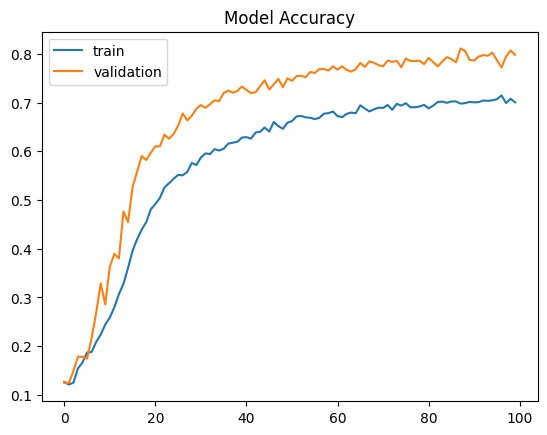

In [23]:
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.show()

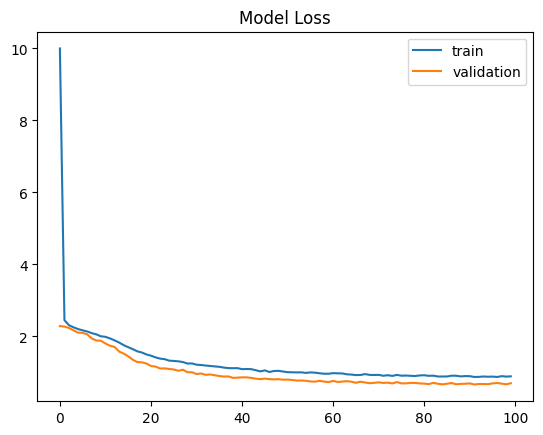

In [24]:
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

# Test

In [33]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [34]:
filename = "/kaggle/input/urbansound8k/fold5/100032-3-0-0.wav"
sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)

In [35]:
result_array = model.predict(mfccs_features_scaled)

1/1 [==============================] - 0s 16ms/step


In [36]:
result = np.argmax(result_array[0])

In [37]:
class_names[result]

'dog_bark'